In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import glob
import os
import peakutils
import logging
import datetime
import warnings
from lmfit.models import PseudoVoigtModel, GaussianModel
from jupyterthemes import jtplot

In [42]:
from xps.xps_sw import *
from xps.xps_import import *
from xps.xps_analysis import *
from xps.xps_bg import *
jtplot.style('default', grid=False)
logging.getLogger().setLevel(logging.CRITICAL)
warnings.filterwarnings("ignore")

plt.rcParams['errorbar.capsize'] = 8
plt.rcParams['font.size'] = 18
plt.rcParams['lines.linewidth'] = 2.5
plt.rc('font', size= 18)
plt.rc('legend', fontsize= 15)
plt.rc('xtick', labelsize= 18)
plt.rc('ytick', labelsize= 18)
plt.rc('axes', labelsize=18)
plt.rc('axes', titlesize=18)

In [43]:
def plot_xp_regions(experiments : list, regions : list, colors : list = [], ncols: int = 3):
    """Subplots all regions of a list of experiments (unnormalised)"""
    rows = int(np.ceil(len(regions) / ncols))

    fig, ax = plt.subplots(rows, ncols, figsize=(16, 8))
    fig.add_subplot(111, frameon=False, xticks=[], yticks=[])  # Used for common xlabel and ylabel

    for i,r in enumerate(regions):
        for c,xp in enumerate(experiments):
            j, k = i//ncols, i%ncols

            if i == len(regions) - 1:   # Set labels from last region
                lb = xp.name

            else:
                lb='__nolabel__'

            try:
                li = plot_region(xp, r, ax=ax[j][k], lb=lb)
                ax[j][k].legend(loc='center left')
                ax[j][k].invert_xaxis()
                
            except KeyError:    # Auto-exclude regions not recorded for a particular experiment
                pass
        ax[j][k].set_yticks([])
        ax[j][k].text(s=r.replace('_', ' '), x=(ax[j][k].get_xlim()[0]*0.999), y=(ax[j][k].get_ylim()[1]*0.9))

#
        if len(experiments)%2 == 0:
            ax[j][k].invert_xaxis()
    plt.xlabel('\nEnergy [eV]', ha='center')
    plt.tight_layout(w_pad=0.5, h_pad=0.5, pad=0.1)
    return ax

# FBI metOH and FBI - Ba fits

## Import data

In [44]:
path = '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_metOH/**/*.xy'

files = glob.glob(path, recursive=True)
files.sort()
files_new = []
for f in files:
    if '/proc' in f:
        files_new.append(f)
filesAli = files_new
filesAli

['/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_metOH/2020_09_11_Cu/proc/20200911_Cu_clean3.xy',
 '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_metOH/2020_09_11_Cu/proc/20200915_Cu_metOH_400pulses.xy',
 '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_metOH/2020_09_11_Cu/proc/20200916_Cu_FBI_metOH_400pulses.xy',
 '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_metOH/2020_09_11_Cu/proc/20200917_Cu_FBI_metOH_400pulses_BaCl_subl_30min.xy',
 '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_metOH/2020_09_11_Cu/proc/20200917_Cu_FBI_metOH_400pulses_BaCl_subl_3h.xy',
 '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_metOH/2020_09_11_Cu/proc/20200917_Cu_FBI_metOH_400pulses_annealing.xy']

In [45]:
path = '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021*/**/*.uxy'

files = glob.glob(path, recursive=True)
files.sort()
files_new = []
for f in files:
    if '/proc' in f:
        files_new.append(f)
filesSubl = files_new
filesSubl

['/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_01_18_Cu/proc/20210119_7-Cu_FBI_subl_05min.uxy',
 '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_01_18_Cu/proc/20210119_7-Cu_FBI_subl_10min.uxy',
 '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_01_18_Cu/proc/20210119_7-Cu_FBI_subl_15min.uxy',
 '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_01_18_Cu/proc/20210119_7-Cu_FBI_subl_20min.uxy',
 '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_01_18_Cu/proc/20210119_7-Cu_clean.uxy',
 '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_01_21_Cu/proc/20210121_8-Cu_FBI_subl_05min.uxy',
 '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_01_21_Cu/proc/20210121_8-Cu_clean.uxy',
 '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_01_21_Cu/proc/20210122_8-Cu_FBI_subl_15min.uxy',
 '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_01_21_Cu/proc/20210122_8-Cu_FBI_subl_60min.uxy',
 '/Users/pabloherrero/sabat/

In [68]:
ali_exps = [read_processed_xp(f) for f in filesAli]

In [47]:
subl_exps = [read_processed_xp(f) for f in filesSubl]

In [48]:
fbiBa_exps = []
fbi_exps = []
for xp in subl_exps:
    if 'BaCl' in xp.name: fbiBa_exps.append(xp); #print(xp.name) 
    elif 'FBI' in xp.name: fbi_exps.append(xp); print(xp.name)

7-Cu_FBI_subl_5min
7-Cu_FBI_subl_10min
7_Cu-FBI_subl_15min
7-Cu_FBI_subl_20min
8-Cu_FBI_subl_05min
8-Cu_FBI_subl_15min
8-Cu_FBI_subl_60min
9-Cu_FBI_subl_2p5min
10a-Cu_FBI_subl_10min_1p9V
10b-Cu_FBI_subl_10min_1p95V
10c-Cu_FBI_subl_10min_2V
11-Cu_FBI_subl_20min
12-Cu_FBI_subl_20min
13-Cu_FBI_subl_60min
14-Cu_FBI_subl_8min


In [49]:
fbiBa_exps[0].color = 'b'
fbi_exps[0].color = 'b'
fbi_exps[1].color = 'g'
fbi_exps[2].color = 'r'
fbi_exps[7].color = 'g'


fbiBa_exps[1].color = 'r'
fbi_exps[8].color = 'm'

fbiBa_exps[2].color = 'g'
fbi_exps[9].color = 'k'

fbi_sel = [fbi_exps[0], fbi_exps[7]]

In [50]:
clean_exp = read_processed_xp(filesSubl[4])

##### Data from xps_stoichiom_FBI_BaCl2_subl_Cu_2021.ipynb

In [51]:
np.matrix([[0.65132385, 0.0011614 ],
         [1.08637052, 0.00327288],
        [0.4755159 , 0.00085199]])

matrix([[6.51323850e-01, 1.16140000e-03],
        [1.08637052e+00, 3.27288000e-03],
        [4.75515900e-01, 8.51990000e-04]])

In [52]:
names = ['0.65 Layers', '0.47 Layers']
for i,xp in enumerate(fbi_sel):
    xp.name = names[i]

In [53]:
ali_exps[2].name = 'ALI 400 pulses'
ali_exps[5].name = 'ALI 400 pulses, 120ºC anneal'

In [69]:
ali_exps[2].color = 'purple'

In [77]:
ali_exps[1].path

'/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_metOH/2020_09_11_Cu/proc/20200915_Cu_metOH_400pulses.xy'

## Subtract solvent data

In [54]:
region = 'O_1s'
def subtract_region_counts(xp: XPS_experiment, xpRef: XPS_experiment, region: str, inplace=False):
    dif = xp.dfx[region].dropna().counts.sub(xpRef.dfx[region].dropna().counts )
    if inplace:
        xp.dfx[region].counts.update(dif)
        return xp
    else:
        xpNew = deepcopy(xp)
        xpNew.dfx[region].counts = dif
    return xpNew

def compress_noisy_region(xp: XPS_experiment, xpRef: XPS_experiment, region, lb: tuple = None, inplace: bool = False):
    fig, ax = plt.subplots(1, 2, figsize=(12, 8))
    if lb == None: lb = (xp.name, xpRef.name)
    df, dfRef = xp.dfx[region].dropna(), xpRef.dfx[region].dropna()

    ax[0].plot(df.energy, df.counts, '-b', label=lb[0] + ' (bg.)')
    ax[0].plot(dfRef.energy, dfRef.counts, '-r', label=lb[1] + ' (sg.)')

    bl_factor = np.average(baseline_als(dfRef.counts))
    scale = bl_factor / np.max(df.counts)
    y_scale = df.counts * scale

    ax[1].plot(df.energy, y_scale, '-b', label='noise compressed')
    ax[1].plot(dfRef.energy, dfRef.counts , '-r', label=lb[1]+' (sg.)')
    ax[1].legend(); ax[0].legend()
    if inplace:
        xp.dfx[region] = pd.DataFrame([xp.dfx[region].energy, y_scale]).T
        return xp
    else:
        xpNew = deepcopy(xp)
        xpNew.dfx[region].counts = y_scale
    return xpNew

In [169]:
def inplace_dec(func):
    def func_wrapper(*args, **kwargs):
        func(*args, **kwargs)
        print(args)
        print(kwargs)
        if kwargs['inplace']:
            xp = xpNew
            return xp
        else:
            xpNew = deepcopy(xp)
        return xpNew
    return func_wrapper

@inplace_dec
def subtract_region_counts(xp: XPS_experiment, xpRef: XPS_experiment, region: str, inplace=False):
    dif = xp.dfx[region].dropna().counts.sub(xpRef.dfx[region].dropna().counts )
    xpNew = deepcopy(xp)
    xpNew.dfx[region].counts = dif

@inplace_dec
def compress_noisy_region(xp: XPS_experiment, xpRef: XPS_experiment, region, lb: tuple = None, inplace: bool = False):
    fig, ax = plt.subplots(1, 2, figsize=(12, 8))
    if lb == None: lb = (xp.name, xpRef.name)
    df, dfRef = xp.dfx[region].dropna(), xpRef.dfx[region].dropna()

    ax[0].plot(df.energy, df.counts, '-b', label=lb[0] + ' (bg.)')
    ax[0].plot(dfRef.energy, dfRef.counts, '-r', label=lb[1] + ' (sg.)')

    bl_factor = np.average(baseline_als(dfRef.counts))
    scale = bl_factor / np.max(df.counts)
    y_scale = df.counts * scale

    ax[1].plot(df.energy, y_scale, '-b', label='noise compressed')
    ax[1].plot(dfRef.energy, dfRef.counts , '-r', label=lb[1]+' (sg.)')
    ax[1].legend(); ax[0].legend()
    xpNew = deepcopy(xp)
    xpNew.dfx[region].counts = y_scale

In [70]:
region = 'Cu_2p'
df, dfRef = ali_exps[0].dfx[region].dropna(), clean_exp.dfx[region].dropna()
scale_factor = (np.max(dfRef.counts) - np.min(dfRef.counts)) / (np.max(df.counts) - np.min(df.counts))
for xp in ali_exps:
    scale_dfx(xp, scale_factor=scale_factor, inplace=True)


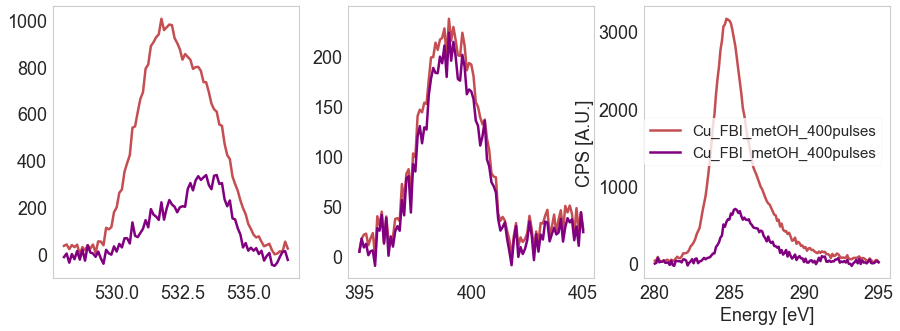

In [71]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i,r in enumerate(['O_1s', 'N_1s', 'C_1s']):
    plot_region(ali_exps[2], r, ax=ax[i], col='r')
    subtract_region_counts(ali_exps[2], ali_exps[1], r, inplace=True)
    plot_region(ali_exps[2], r, ax=ax[i])

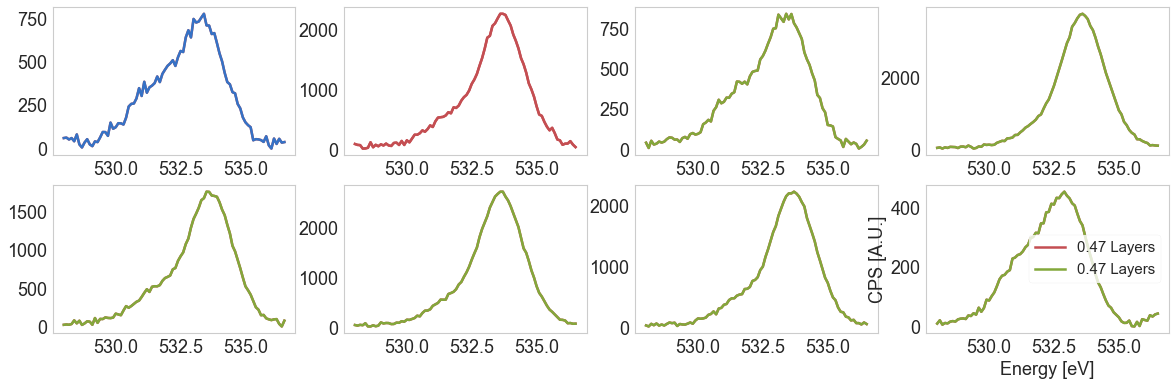

In [72]:
fig, ax = plt.subplots(2, 4, figsize=(20, 6))
for j, xp in enumerate(fbi_exps[:8]):
    i, k = j%2, j//2
    plot_region(xp, 'O_1s', ax=ax[i][k], col='r')
    trim_spectra(xp, ali_exps[1], 'O_1s', inplace=True)
    plot_region(xp, 'O_1s', ax=ax[i][k], )

## Overview regions

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a2365ce80>,
      dtype=object)

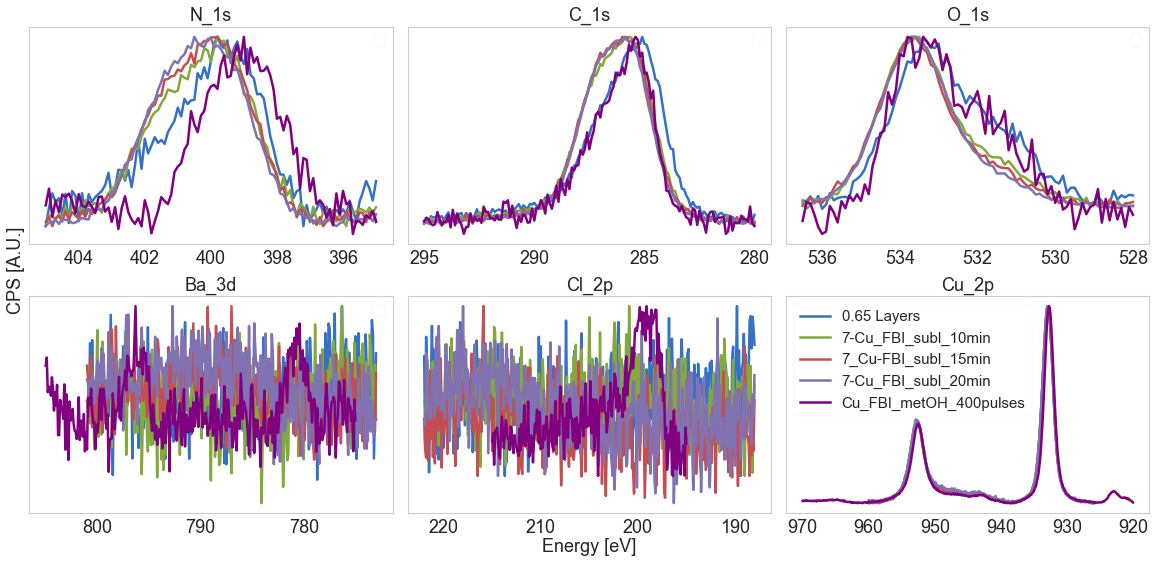

In [73]:
regions= ['N_1s', 'C_1s', 'O_1s', 'Ba_3d', 'Cl_2p', 'Cu_2p']
plot_normal_regions(fbi_exps[:4] + [ali_exps[2]], regions)

[[]]

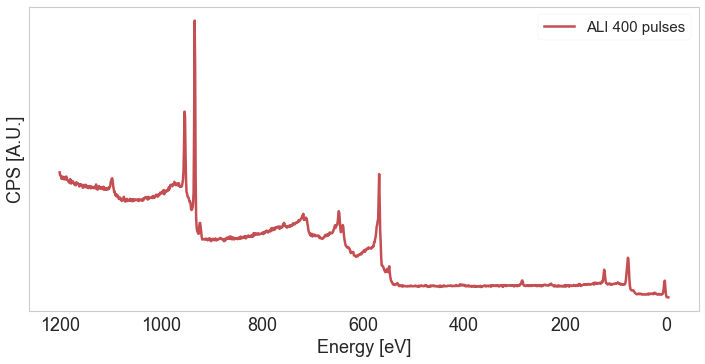

In [40]:
plot_region(ali_exps[2], 'overview_')
plt.gcf().set_figwidth(12)
plt.gca().set(yticks=[])

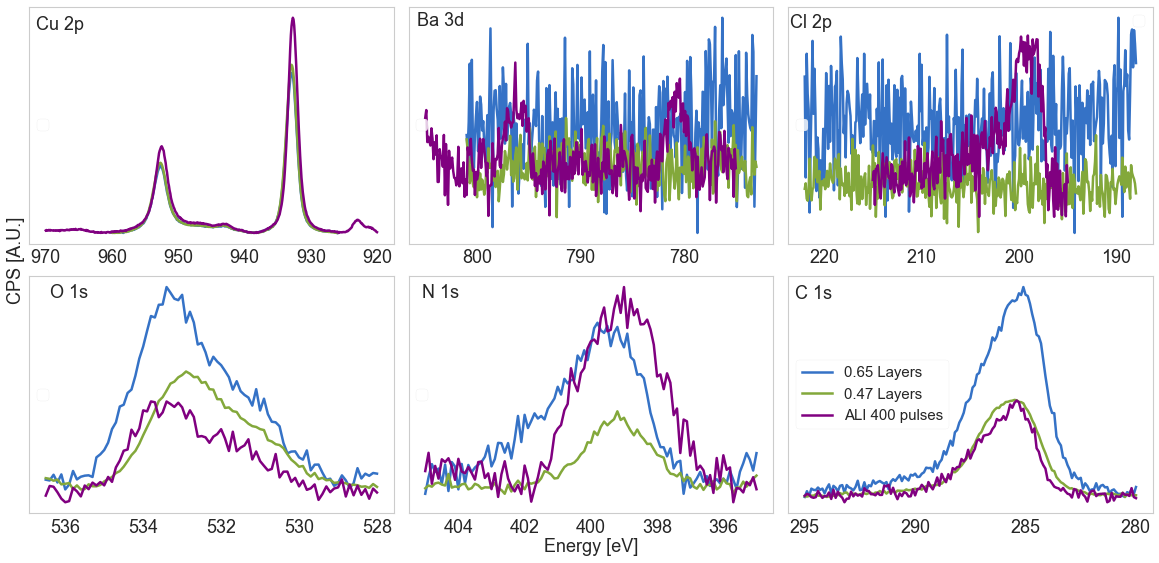

In [60]:
regions= ['Cu_2p', 'Ba_3d', 'Cl_2p', 'O_1s', 'N_1s', 'C_1s']
plot_xp_regions(fbi_sel + [ali_exps[2]], regions, ncols=3);

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a30a502e8>,
      dtype=object)

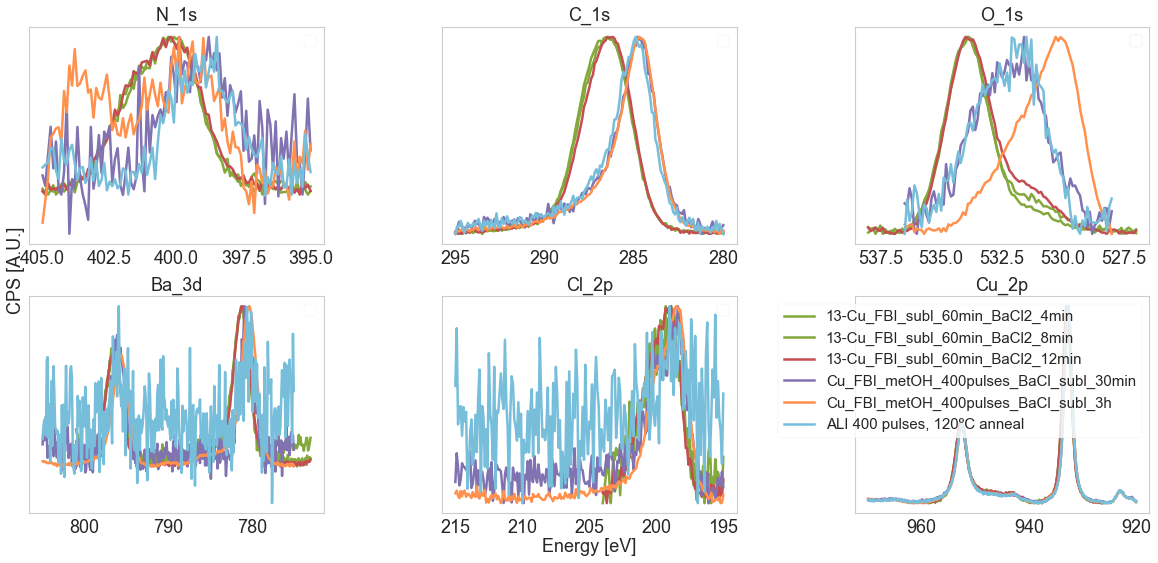

In [73]:
regions= ['N_1s', 'C_1s', 'O_1s', 'Ba_3d', 'Cl_2p', 'Cu_2p']
plot_normal_regions(fbiBa_exps[2:5] + ali_exps[3:], regions)

## Fit O 1s

In [8]:
region = 'O_1s'

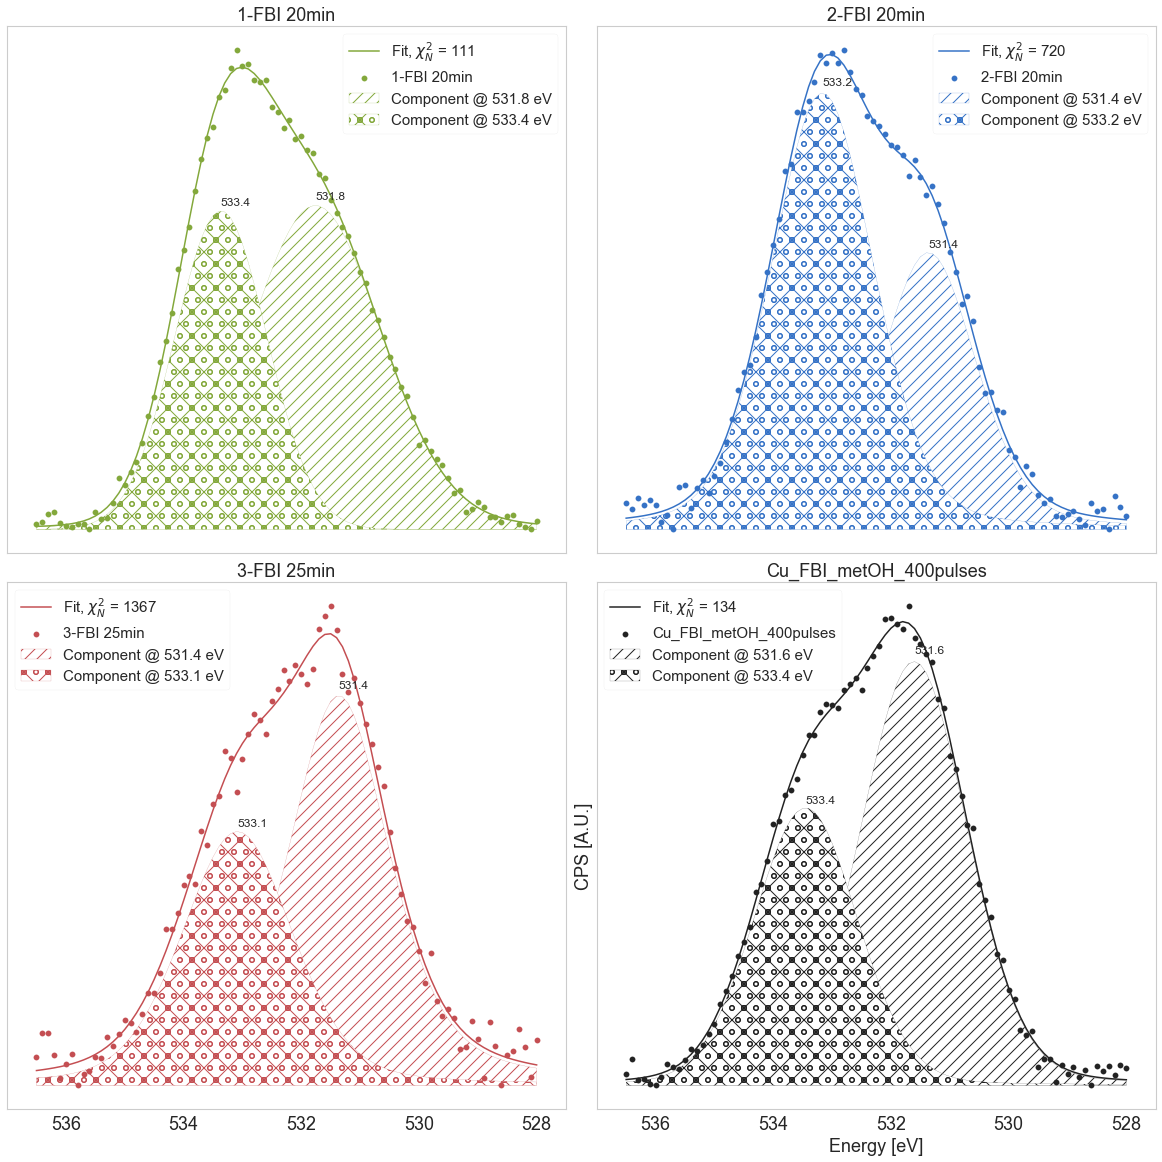

In [43]:
ncols = 2
fig, ax = plt.subplots(2, ncols, sharex=True, figsize=(16, 16), )
region = 'O_1s'
for i,xp in enumerate(fbi_exps[:3] + [proc_exps[2]]):
    j, k = i//ncols, i%ncols
    Fn = XPFit(xp, region=region)

    Fn.double_voigt(sepPt=532)
    Fn.plot( ax = ax[j,k], )
    ax[j,k].set(title=xp.name, yticks=[])
    ax[j,k].legend()
    Fn.set_areas()
ax[j,k].invert_xaxis()
    
plt.tight_layout(w_pad=0.5, h_pad=0.5, pad=0.1)
# plt.gcf().savefig('/Users/pabloherrero/Dropbox/phd/papers/fbi_cu_sublimation/fits_o1s.png', dpi=200)

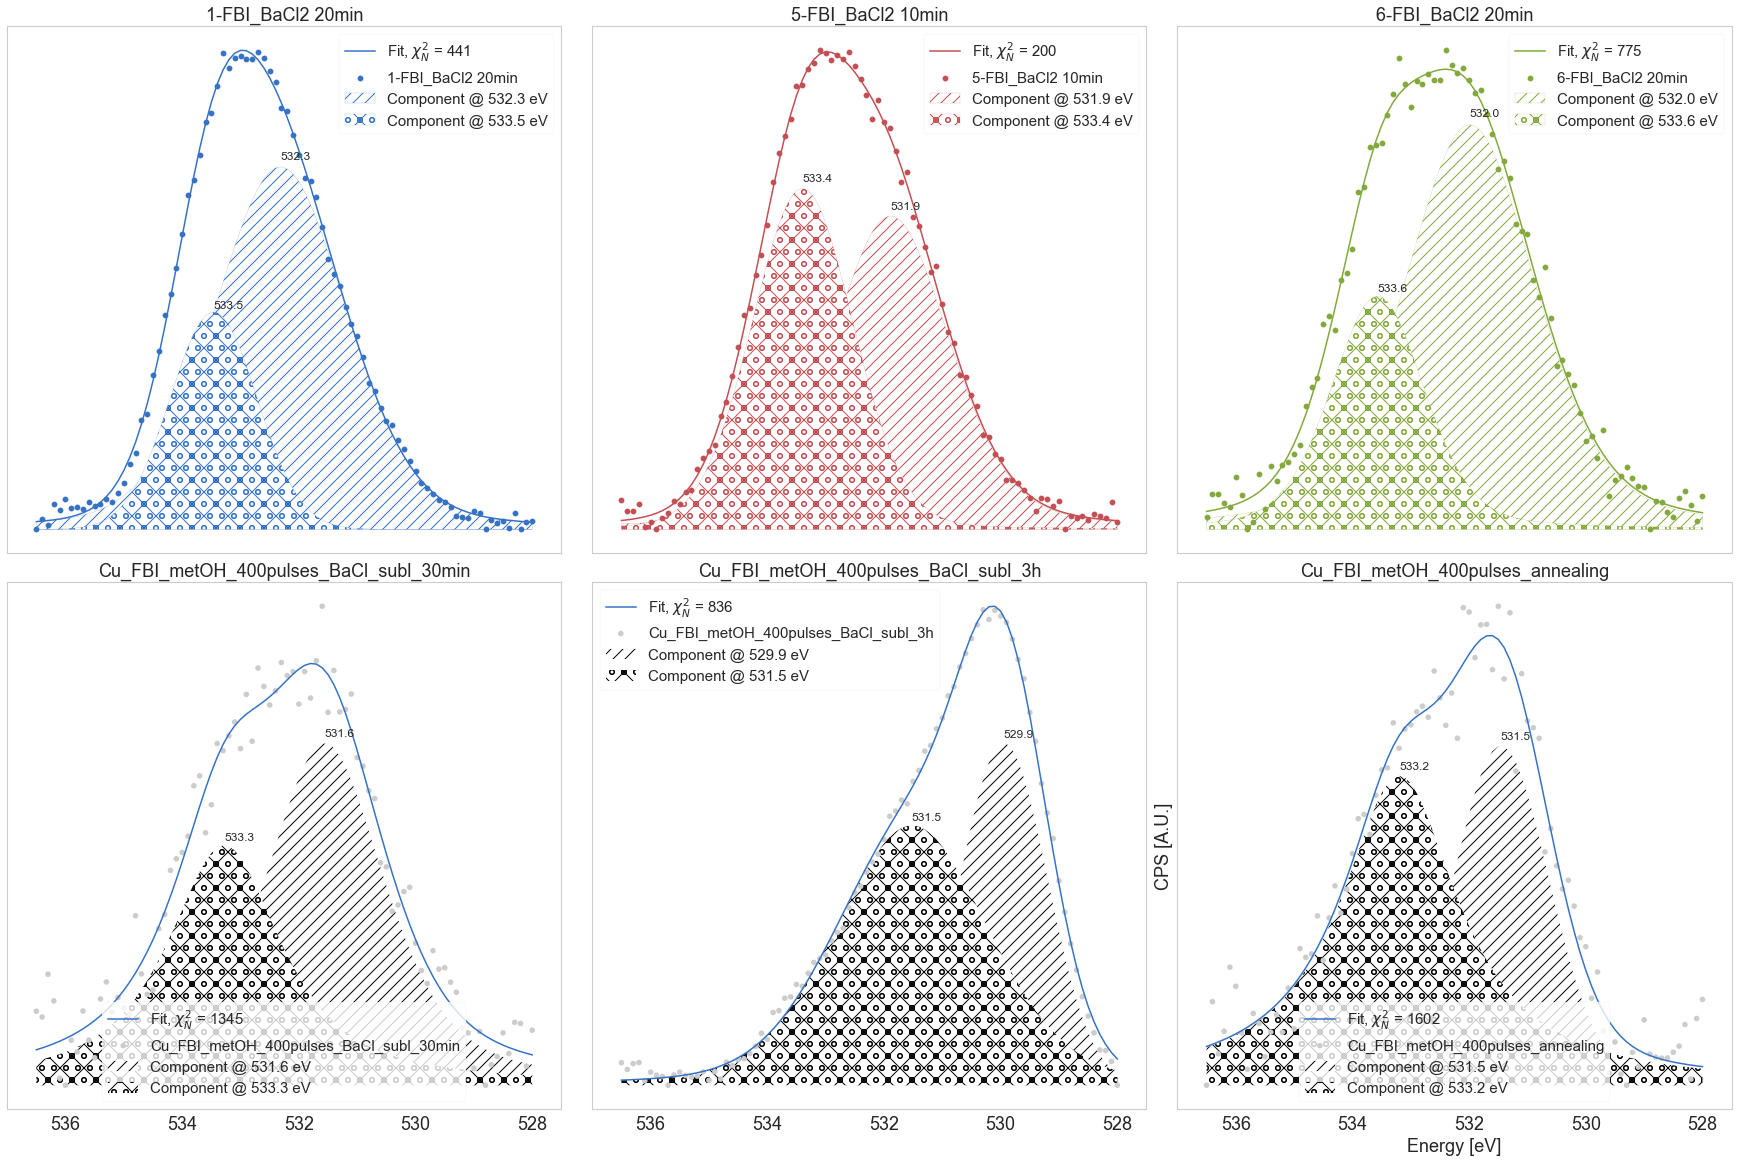

In [46]:
ncols = 3
fig, ax = plt.subplots(2, ncols, sharex=True, figsize=(8*ncols, 16), )
region = 'O_1s'
for i,xp in enumerate(fbiBa_exps + proc_exps[3:]):
    j, k = i//ncols, i%ncols
    Fn = XPFit(xp, region=region)

    Fn.double_voigt(sepPt=532)
    Fn.plot( ax = ax[j,k], )
    ax[j,k].set(title=xp.name, yticks=[])
    ax[j,k].legend()
    Fn.set_areas()
ax[j,k].invert_xaxis()
    
plt.tight_layout(w_pad=0.5, h_pad=0.5, pad=0.1)


In [231]:
region = 'O_1s'
table_fit_area(fbi_sel, region=region)

comp	center	fwhm	amplitude	area	
v1	531.76	 2.66	 1546.67	 0.60
v2	533.37	 1.84	 996.47	 0.40
v1	531.79	 2.18	 1400.00	 0.57
v2	533.37	 2.05	 1093.72	 0.43
v1	531.25	 2.33	 3376.04	 0.58
v2	533.00	 2.05	 2467.41	 0.42


In [232]:
table_fit_area(fbiBa_exps, region='O_1s')

comp	center	fwhm	amplitude	area	
v1	532.32	 2.69	 3187.10	 0.73
v2	533.46	 1.75	 1127.93	 0.27
v1	531.89	 2.39	 1518.29	 0.53
v2	533.40	 2.04	 1295.04	 0.47
v1	531.99	 2.68	 2405.46	 0.71
v2	533.57	 1.89	 954.18	 0.29


## Fit N 1s 

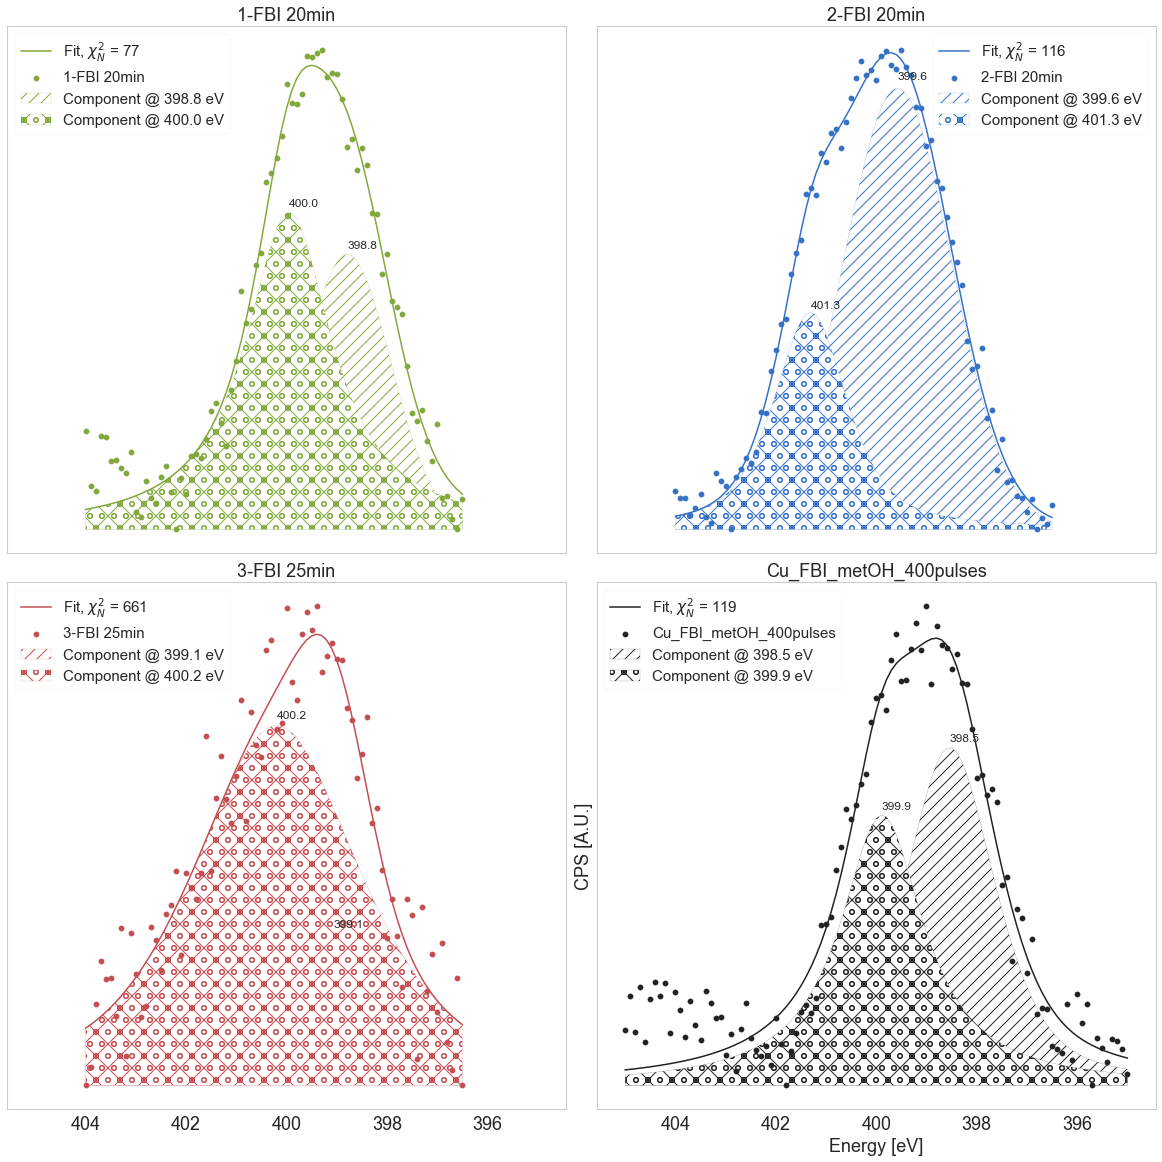

In [48]:
ncols = 2
fig, ax = plt.subplots(2, ncols, sharex=True, figsize=(16, 16), )
region = 'N_1s'
for i,xp in enumerate(fbi_exps[:3] + [proc_exps[2]]):
    j, k = i//ncols, i%ncols
    Fn = XPFit(xp, region=region)

    Fn.double_voigt(sepPt=400)
    Fn.plot( ax = ax[j,k], )
    ax[j,k].set(title=xp.name, yticks=[])
    ax[j,k].legend()
    Fn.set_areas()
ax[j,k].invert_xaxis()
    
plt.tight_layout(w_pad=0.5, h_pad=0.5, pad=0.1)
# plt.gcf().savefig('/Users/pabloherrero/Dropbox/phd/papers/fbi_cu_sublimation/fits_o1s.png', dpi=200)

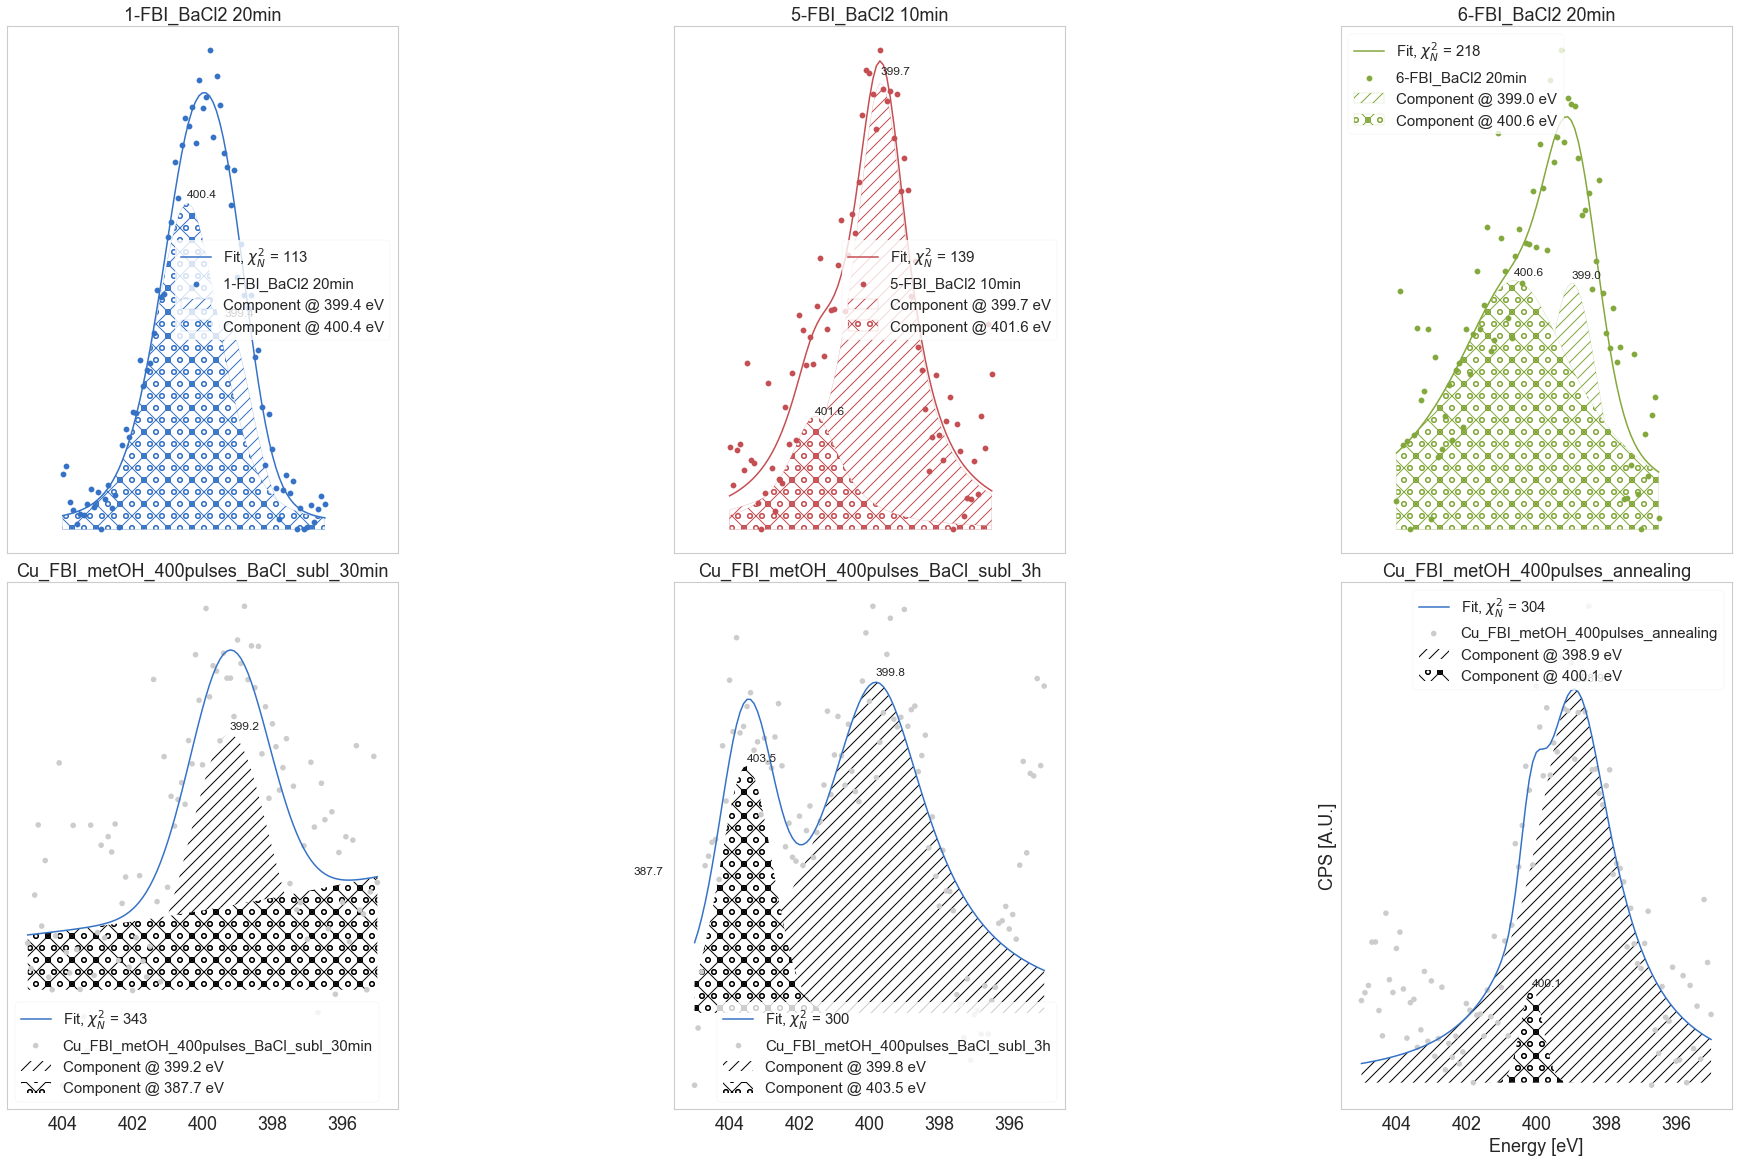

In [49]:
ncols = 3
fig, ax = plt.subplots(2, ncols, sharex=True, figsize=(8*ncols, 16), )
region = 'N_1s'
for i,xp in enumerate(fbiBa_exps + proc_exps[3:]):
    j, k = i//ncols, i%ncols
    Fn = XPFit(xp, region=region)

    Fn.double_voigt(sepPt=400)
    Fn.plot( ax = ax[j,k], )
    ax[j,k].set(title=xp.name, yticks=[])
    ax[j,k].legend()
    Fn.set_areas()
ax[j,k].invert_xaxis()
    
plt.tight_layout(w_pad=0.5, h_pad=0.5, pad=0.1)


In [54]:
eba52 = 66 + 2 # eV
eph1 = 110 # eV
eph2 = 1486.7 # eV
ek = eph1 - eba52
eph2 - ek

1444.7

## Fit C 1s

Modify user pars
Modify user pars
Modify user pars
Modify user pars
Modify user pars
Modify user pars
Modify user pars


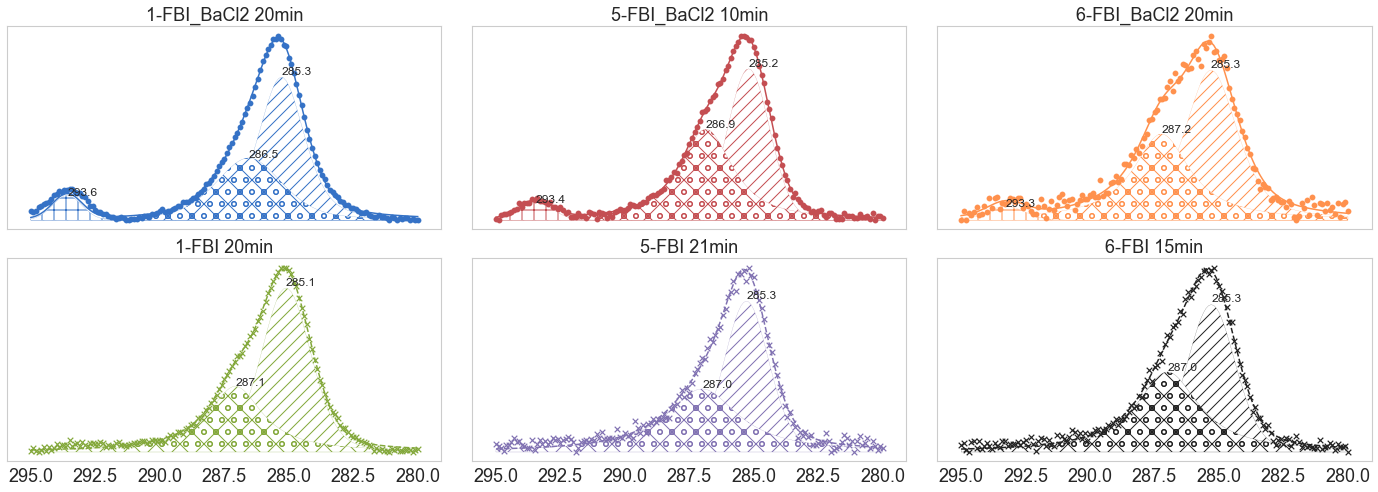

In [26]:
fig, (ax1, ax2) = plt.subplots(2, 3, sharex=True, figsize=(19, 7), )
region = 'C_1s'
pars = [100, 293.3, 1]
bounds = [(50, 500), (293, 294), (0.5, 2.)]

for i,xp in enumerate(fbiBa_exps):
    Fn = XPFit(xp, region=region)
    if i == 2: Fn.preset_pars(key='v1_amplitude', val=2200)
    if i == 0 : 
        Fn.preset_pars(key='v2_amplitude', val=3400)
#         Fn.preset_pars(key='v2_fraction', val=0.7)
        

    fitvv = Fn.double_voigt(sepPt=286.5)
    Fn.gauss_shoulder(fitvv, par_g=pars, bounds_g=bounds)
    Fn.plot( ax = ax1[i])
    ax1[i].set(title=xp.name, yticks=[])
    Fn.set_areas()
    

amp = [3000, 2000, 3300]
for i, xp in enumerate(fbi_sel):
    Fn = XPFit(xp, region=region)
    Fn.preset_pars(key='v1_amplitude', val=amp[i])
    
    Fn.double_voigt(sepPt=286.5)
    Fn.plot( ax = ax2[i], marker='x', ls = 'dashed')
    ax2[i].invert_xaxis()
    ax2[i].set(title=xp.name, yticks=[])
    Fn.set_areas()
plt.tight_layout(w_pad=0.5, h_pad=0.5, pad=0.1)
ax2[i].get_legend().remove()
ax2[i].set(xlabel='', ylabel='')
plt.gcf().savefig('/Users/pabloherrero/Dropbox/phd/papers/fbi_cu_sublimation/fits_c1s.png', dpi=200)

Modify user pars


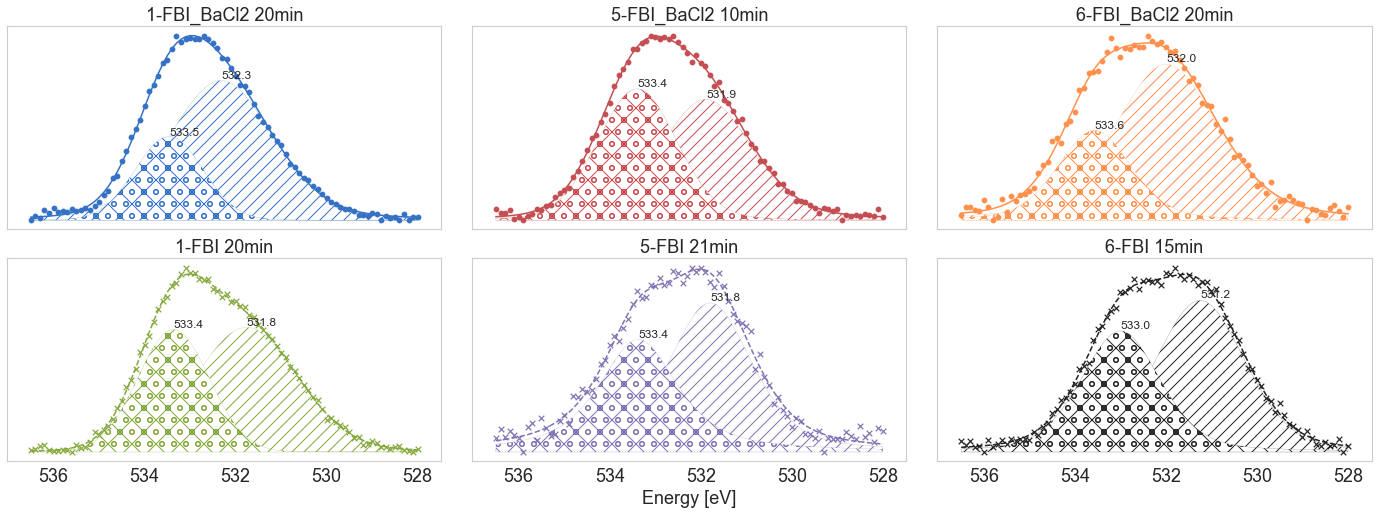

In [17]:
fig, (ax1, ax2) = plt.subplots(2, 3, sharex=True, figsize=(19, 7), )
region = 'O_1s'

for i,xp in enumerate(fbiBa_exps):
    Fn = XPFit(xp, region=region)

    Fn.double_voigt(sepPt=532)
    Fn.plot( ax = ax1[i])
    ax1[i].set(title=xp.name, yticks=[])
    Fn.set_areas()
    
for i, j in enumerate([0, 8, 9]):
    Fn = XPFit(fbi_exps[j], region=region)
    if i == 1: 
        Fn.preset_pars(key='v1_amplitude', val=1400)
        ax2[i].set_xlabel('Energy [eV]')

    Fn.double_voigt(sepPt=532)
    Fn.plot( ax = ax2[i], marker='x', ls = 'dashed')
    ax2[i].invert_xaxis()
    ax2[i].set(title=fbi_exps[j].name, yticks=[])
    Fn.set_areas()
plt.tight_layout(w_pad=0.5, h_pad=0.5, pad=0.1)
ax2[i].get_legend().remove()
ax2[i].set(xlabel='', ylabel='')
plt.gcf().savefig('/Users/pabloherrero/Dropbox/phd/papers/fbi_cu_sublimation/fits_o1s.png', dpi=200)

In [197]:
region = 'C_1s'
table_fit_area(fbi_sel, region='C_1s')

comp	center	fwhm	amplitude	area	
v1	285.11	 2.27	 3000.00	 0.64
v2	287.07	 2.55	 1795.84	 0.36
v1	285.29	 2.05	 2000.00	 0.55
v2	287.01	 3.37	 1850.13	 0.45
v1	285.30	 2.20	 3300.00	 0.53
v2	287.00	 2.93	 3257.07	 0.47


In [228]:
region = 'C_1s'
table_fit_area(fbiBa_exps, region='C_1s')

comp	center	fwhm	amplitude	area	
v1	285.40	 2.28	 6483.81	 0.71
v2	287.26	 2.35	 2267.05	 0.23
g1	293.59	 1.34	 500.00	 0.06
v1	285.20	 1.92	 1774.18	 0.49
v2	286.86	 2.47	 1888.27	 0.47
g1	293.45	 1.53	 162.49	 0.04
v1	285.31	 2.42	 2200.00	 0.57
v2	287.23	 2.66	 1641.41	 0.40
g1	293.26	 1.70	 113.43	 0.03


## Table results

In [182]:
region = 'C_1s'
exps = fbiBa_exps

def table_fit_area(exps: list, region: str):
    """Print a table with fit results and relative areas dict"""
    par_table = ['center', 'fwhm', 'amplitude', 'area']
    head = 'comp\t'

    for par in par_table: 
        head += '%s\t'%par

    print(head)

    for xp in exps:
        fit = xp.fit[region]
        for i, comp in enumerate(fit.components):
            pref = comp.prefix
            line = pref[:-1] + '\t'

            for par in par_table[:-1]:
                line += '%.2f\t '%fit.values[pref + par]        
            line += '%.2f'%xp.area[region+'_'+pref]

            print(line)

In [505]:
table_fit_area(fbiBa_exps, region)

comp	center	fwhm	area	
v1	285.40	 2.28	 0.71
v2	287.27	 2.35	 0.23
g1	293.59	 1.34	 0.06
v1	285.18	 1.88	 0.50
v2	286.78	 2.57	 0.46
g1	293.44	 1.56	 0.05
v1	285.31	 2.42	 0.57
v2	287.23	 2.66	 0.40
g1	293.26	 1.70	 0.03


### Latex style + custom fbi/fbi-ba arrangement

In [96]:
def table_fbifbiba(region):
    """Print a table with fit results and relative areas dict"""
    par_table = ['center', 'fwhm', 'area']
    head = 'exp & comp & '
    head2 = ''
    for par in par_table: 
        head += '%s & '%par
        head2 += '& FBI & FBI-Ba & '
    print(region, ' fits')
    print(head)
    print(head2)

    for xpba, xp in zip(fbiBa_exps, fbi_sel):
        fit = xp.fit[region]
        fitba = xpba.fit[region]
        line = '\hline\n '
        for i, comp in enumerate(fitba.components):
            pref = comp.prefix
            line += '{} & ' + pref[:-1] + ' & '
            for par in par_table[:-1]:
                if i < 2:
                    line += '%.2f & '%fit.values[pref + par]
                line += '%.2f & '%fitba.values[pref + par]
            if i < 2:
                line += '%.2f & '%xp.area[region+'_'+pref]
            line += '%.2f \\\ \n'%xpba.area[region+'_'+pref]
        print(line)

In [184]:
table_fbifbiba('C_1s')

C_1s  fits
exp & comp & center & fwhm & area & 
& FBI & FBI-Ba & & FBI & FBI-Ba & & FBI & FBI-Ba & 
\hline
 {} & v1 & 285.11 & 285.40 & 2.27 & 2.28 & 0.64 & 0.71 \\ 
{} & v2 & 287.07 & 287.27 & 2.55 & 2.35 & 0.36 & 0.23 \\ 
{} & g1 & 293.59 & 1.34 & 0.06 \\ 

\hline
 {} & v1 & 285.29 & 285.18 & 2.05 & 1.88 & 0.55 & 0.50 \\ 
{} & v2 & 287.01 & 286.78 & 3.37 & 2.57 & 0.45 & 0.46 \\ 
{} & g1 & 293.44 & 1.56 & 0.05 \\ 

\hline
 {} & v1 & 285.30 & 285.31 & 2.20 & 2.42 & 0.53 & 0.57 \\ 
{} & v2 & 287.00 & 287.23 & 2.93 & 2.66 & 0.47 & 0.40 \\ 
{} & g1 & 293.26 & 1.70 & 0.03 \\ 



In [98]:
table_fbifbiba('O_1s')

O_1s  fits
exp & comp & center & fwhm & area & 
& FBI & FBI-Ba & & FBI & FBI-Ba & & FBI & FBI-Ba & 
\hline
 {} & v1 & 531.76 & 532.32 & 2.66 & 2.69 & 0.60 & 0.73 \\ 
{} & v2 & 533.37 & 533.46 & 1.84 & 1.75 & 0.40 & 0.27 \\ 

\hline
 {} & v1 & 531.79 & 531.89 & 2.18 & 2.39 & 0.57 & 0.53 \\ 
{} & v2 & 533.37 & 533.40 & 2.05 & 2.04 & 0.43 & 0.47 \\ 

\hline
 {} & v1 & 531.25 & 531.99 & 2.33 & 2.68 & 0.58 & 0.71 \\ 
{} & v2 & 533.00 & 533.57 & 2.05 & 1.89 & 0.42 & 0.29 \\ 



In [99]:
table_fbifbiba('N_1s')

N_1s  fits
exp & comp & center & fwhm & area & 
& FBI & FBI-Ba & & FBI & FBI-Ba & & FBI & FBI-Ba & 
\hline
 {} & v1 & 398.79 & 399.37 & 2.05 & 1.77 & 0.41 & 0.31 \\ 
{} & v2 & 399.95 & 400.44 & 2.09 & 2.28 & 0.59 & 0.69 \\ 

\hline
 {} & v1 & 398.72 & 399.67 & 2.05 & 1.93 & 0.67 & 0.81 \\ 
{} & v2 & 400.88 & 401.56 & 5.06 & 1.83 & 0.33 & 0.19 \\ 

\hline
 {} & v1 & 398.74 & 399.13 & 2.26 & 2.15 & 0.72 & 0.60 \\ 
{} & v2 & 401.23 & 401.35 & 2.06 & 3.33 & 0.28 & 0.40 \\ 



# Compare data to SESSA simulation

In [14]:
file = '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/SESSA/FBI-Cu_ML.dat'
df = pd.read_csv(file, sep='\s+', skiprows=20, header=None)
df.drop([2,3,4,5], axis=1, inplace=True)
df.columns = ['energy', 'counts']
df.set_index('energy')

,counts
energy,
-986.600000,-3.953186e-06
-986.111700,-4.208640e-06
-985.623400,-4.466087e-06
-985.135100,-4.725392e-06
-984.646900,-4.986262e-06
-984.158600,-5.248348e-06
-983.670300,-5.511495e-06
-983.182000,-5.775362e-06
-982.693700,-6.039555e-06


[None, (-295, -280)]

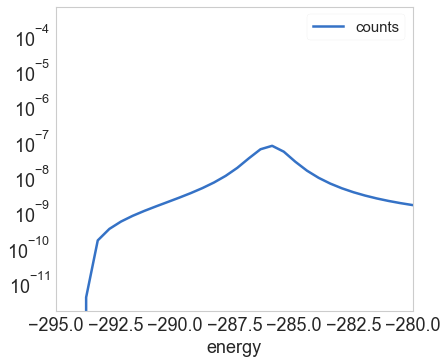

In [19]:
df.plot('energy', 'counts')
plt.gca().set(xlim=(-295,-280), yscale='log')